<a href="https://colab.research.google.com/github/jcdumlao14/ESS11DataAnalysis/blob/main/Multivariable_Regression_Predictive_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariable Regression / Predictive Modelling**

1. **Defining the Outcome (Y)**: CVD
 - As before, we need to construct a binary CVD variable since the direct variable isn't present:
   - **hltprhc**: Health problems, last 12 months: heart or circulation problem

2. **Defining Predictors (X)**: Building Nested Models
 - **Model 1: Demographics**(age, sex)
   - **agea**: Age of respondent, calculated
   - **gndr**: Gender
 - **Model 2: + Socioeconomic** (education, income)
   - **edulvlb**: Highest level of education
   - **hinctnta**: Household's total net income, all sources
 - **Model 3: + Lifestyle** (smoking, BMI, alcohol, diet)
   - **cgtsmok**: Cigarette smoking behaviour
   - **BMI**: Calculated Body Mass Index (as previously described using weighta and height)
   - **alcfreq**: How often drink alcohol
   - **etfruit**: How often eat fruit, excluding drinking juice
   - **eatveg**: How often eat vegetables or salad, excluding potatoes
   - **dosprt**: Do sports or other physical activity, how many of last 7 days
 - **Model 4: + Country Fixed Effects or multilevel random intercepts (country)**
   - **cntry**: Country - this needs to be a factor variable in Python.
- Report ORs, SEs, SDs, 90% & 95% CIs, p-values. Provide sample size per model.

3. **Diagnostics**
 - Discrimination: AUC (ROC).
 - Calibration: calibration plot + Brier score.
 - If multilevel: report ICC (for logistic: var_country/(var_country + pi^2/3) approximation) and possibly random slopes for key exposures.

**File outputs**
 - tables/regression_models.csv and fig_roc_calibration.png.


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns
import os  # Import the os module

# --- Helper functions ---
def calculate_odds_ratio_and_ci(model_output):
    odds_ratios = np.exp(model_output.params)
    standard_errors = model_output.bse
    ci_90 = np.exp(model_output.conf_int(alpha=0.1))
    ci_95 = np.exp(model_output.conf_int(alpha=0.05))
    p_values = model_output.pvalues

    results_df = pd.DataFrame({
        'OR': odds_ratios,
        'SE': standard_errors,
        'lower_90CI': ci_90.iloc[:, 0],
        'upper_90CI': ci_90.iloc[:, 1],
        'lower_95CI': ci_95.iloc[:, 0],
        'upper_95CI': ci_95.iloc[:, 1],
        'p_value': p_values
    })

    return results_df

def plot_calibration_curve(y_true, y_prob, ax, model_name):
    from sklearn.calibration import calibration_curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)

    ax.plot(mean_predicted_value, fraction_of_positives, marker='o', label=model_name)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title(f'Calibration Curve ({model_name})')
    ax.legend()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

def analyze_multilevel_logistic_regression(df, formula, group_variable):
    md = smf.mixedlm(formula, data=df, groups=df[group_variable])
    mdf = md.fit()

    vc = mdf.vcov_re
    var_country = vc[group_variable]["Intercept"]
    var_residual = np.pi**2 / 3

    icc = var_country / (var_country + var_residual)

    return mdf, icc


# --- Main analysis ---
try:
    df = pd.read_csv('/content/ESS11.csv', low_memory=False)  # Added low_memory=False
except FileNotFoundError:
    raise FileNotFoundError("Dataset file not found. Check '/content/ESS11.csv' path.")

print("Step 0: Loaded dataset.")

# -------------------------
# 1. Rename and basic checks
# -------------------------
df = df.rename(columns={'hltprhc': 'CVD'})
print("Step 1: Renamed 'hltprhc' to 'CVD'")

# -------------------------
# 2. Data cleaning & required cols
# -------------------------
key_cols = ['weighta', 'height', 'CVD', 'etfruit', 'eatveg', 'dosprt',
            'cgtsmok', 'alcfreq', 'alcwkdy', 'alcwknd', 'edulvlb', 'hinctnta', 'agea', 'gndr', 'cntry']
missing_cols = [c for c in key_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"The following required columns are missing from the dataframe: {missing_cols}")

df = df.dropna(subset=key_cols).copy()
print(f"Step 2: Dropped rows with NA in key columns. Remaining rows: {len(df)}")

# Convert height from cm to meters and compute BMI
df['height_m'] = df['height'] / 100.0
df['BMI'] = df['weighta'] / (df['height_m'] ** 2)
df = df[np.isfinite(df['BMI'])].copy()
print("Step 3: Calculated BMI and removed infinite values.")

if df['CVD'].dtype == object:
    df['CVD'] = df['CVD'].map(lambda x: 1 if str(x).lower() in ['1','yes','true','y','t'] else 0)
    df['CVD'] = df['CVD'].astype(int)
print(f"Unique values in Y (CVD): {np.unique(df['CVD'])}")

# --- Create Region Variable (Example) ---


region_mapping = {
    'AT': 'West',  # Austria
    'BE': 'West',  # Belgium
    'CH': 'West',  # Switzerland
    'CZ': 'East',  # Czech Republic
    'DE': 'West',  # Germany
    'ES': 'South', # Spain
    'FI': 'North', # Finland
    'FR': 'West',  # France
    'GB': 'West',  # United Kingdom
    'HU': 'East',  # Hungary
    'IE': 'West',  # Ireland
    'IT': 'South', # Italy
    'NL': 'West',  # Netherlands
    'NO': 'North', # Norway
    'PL': 'East',  # Poland
    'PT': 'South', # Portugal
    'SE': 'North', # Sweden
    'SI': 'East'   # Slovenia

}

df['region'] = df['cntry'].map(region_mapping)

# Handle missing regions:
if df['region'].isnull().any():
    print("Warning: Missing region values.  Check 'region_mapping'.")
    df['region'] = df['region'].fillna('Unknown') # Or drop rows: df = df.dropna(subset=['region'])

print(f"Unique values in region: {df['region'].unique()}")

# --- Define Models ---
models = {
    'Model 1: Demographics': ['agea', 'gndr'],
    'Model 2: + Socioeconomic': ['agea', 'gndr', 'edulvlb', 'hinctnta'],
    'Model 3: + Lifestyle': ['agea', 'gndr', 'edulvlb', 'hinctnta', 'cgtsmok', 'BMI', 'alcfreq', 'etfruit', 'eatveg', 'dosprt'],
    'Model 4: + Region Fixed Effects': ['agea', 'gndr', 'edulvlb', 'hinctnta', 'cgtsmok', 'BMI', 'alcfreq', 'etfruit', 'eatveg', 'dosprt', 'C(region)'] #Region fixed effects

}

# --- Results Storage ---
results = {}
roc_auc_scores = {}

# --- Diagnostics setup ---
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
axes = axes.flatten()

# --- Model fitting loop ---
for i, (model_name, predictors) in enumerate(models.items()):
    print(f"\n--- Fitting {model_name} ---")

    # --- Model Formula ---
    formula = f"CVD ~ {' + '.join(predictors)}"

    # --- Fit Logistic Regression ---
    if 'C(region)' in formula:  # Model 4
        try:
            model = sm.formula.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            continue
    else:  # Models 1-3
        try:
            model = sm.formula.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            continue

    # --- Store Results ---
    results[model_name] = {}
    results[model_name]['sample_size'] = len(df)

    # --- Calculate ORs and CIs ---
    results_df = calculate_odds_ratio_and_ci(model)
    results[model_name]['coefficients'] = results_df

    # --- Discrimination (AUC) ---
    y_prob = model.predict(df)
    auc = roc_auc_score(df['CVD'], y_prob)
    results[model_name]['auc'] = auc
    roc_auc_scores[model_name] = auc
    print(f"{model_name} AUC: {auc:.3f}")

    # --- Calibration ---
    brier_score = brier_score_loss(df['CVD'], y_prob)
    results[model_name]['brier_score'] = brier_score
    print(f"{model_name} Brier Score: {brier_score:.3f}")

    # --- Calibration Plot ---
    plot_calibration_curve(df['CVD'], y_prob, axes[i], model_name)

# --- Model 4 (Multilevel) ---

# --- Save results to CSV ---
# Create the 'tables' directory if it doesn't exist
if not os.path.exists('tables'):
    os.makedirs('tables')

output_data = []
for model_name, model_results in results.items():
    if "coefficients" in model_results:
        for predictor, row in model_results['coefficients'].iterrows():
            output_data.append([
                model_name,
                predictor,
                model_results['sample_size'],
                row['OR'],
                row['SE'],
                row['lower_90CI'],
                row['upper_90CI'],
                row['lower_95CI'],
                row['upper_95CI'],
                row['p_value'],
                model_results.get('auc', None),
                model_results.get('brier_score', None),
                model_results.get('icc', None)

            ])

output_df = pd.DataFrame(output_data, columns=[
    'Model', 'Predictor', 'SampleSize', 'OR', 'SE', 'Lower90CI', 'Upper90CI',
    'Lower95CI', 'Upper95CI', 'PValue', 'AUC', 'BrierScore','ICC'
])

output_df.to_csv('tables/regression_models.csv', index=False)

# --- Save calibration plot ---
# Create the directories for the figure if they don't exist
if not os.path.exists(os.path.dirname('fig_roc_calibration.png')) and os.path.dirname('fig_roc_calibration.png') != '':  # added check if directory name is empty
    os.makedirs(os.path.dirname('fig_roc_calibration.png'))


plt.tight_layout()
plt.savefig('fig_roc_calibration.png')
plt.close()

print("\n--- Analysis Complete ---")
print("Results saved to tables/regression_models.csv and fig_roc_calibration.png")

print("\n--- Key results  ---")
for model_name, auc in roc_auc_scores.items():
    print(f"{model_name} AUC: {auc:.3f}")

Step 0: Loaded dataset.
Step 1: Renamed 'hltprhc' to 'CVD'
Step 2: Dropped rows with NA in key columns. Remaining rows: 46162
Step 3: Calculated BMI and removed infinite values.
Unique values in Y (CVD): [0 1]
Unique values in region: ['West' 'Unknown' 'South' 'North' 'East']

--- Fitting Model 1: Demographics ---
Model 1: Demographics AUC: 0.745
Model 1: Demographics Brier Score: 0.100

--- Fitting Model 2: + Socioeconomic ---
Model 2: + Socioeconomic AUC: 0.656
Model 2: + Socioeconomic Brier Score: 0.099

--- Fitting Model 3: + Lifestyle ---
Model 3: + Lifestyle AUC: 0.645
Model 3: + Lifestyle Brier Score: 0.098

--- Fitting Model 4: + Region Fixed Effects ---
Model 4: + Region Fixed Effects AUC: 0.636
Model 4: + Region Fixed Effects Brier Score: 0.098

--- Analysis Complete ---
Results saved to tables/regression_models.csv and fig_roc_calibration.png

--- Key results  ---
Model 1: Demographics AUC: 0.745
Model 2: + Socioeconomic AUC: 0.656
Model 3: + Lifestyle AUC: 0.645
Model 4: + 


--- Fitting Model 1: Demographics ---
Model 1: Demographics AUC: 0.745
Model 1: Demographics Brier Score: 0.100

--- Fitting Model 2: + Socioeconomic ---
Model 2: + Socioeconomic AUC: 0.656
Model 2: + Socioeconomic Brier Score: 0.099

--- Fitting Model 3: + Lifestyle ---
Model 3: + Lifestyle AUC: 0.645
Model 3: + Lifestyle Brier Score: 0.098

--- Fitting Model 4: + Region Fixed Effects ---
Model 4: + Region Fixed Effects AUC: 0.636
Model 4: + Region Fixed Effects Brier Score: 0.098


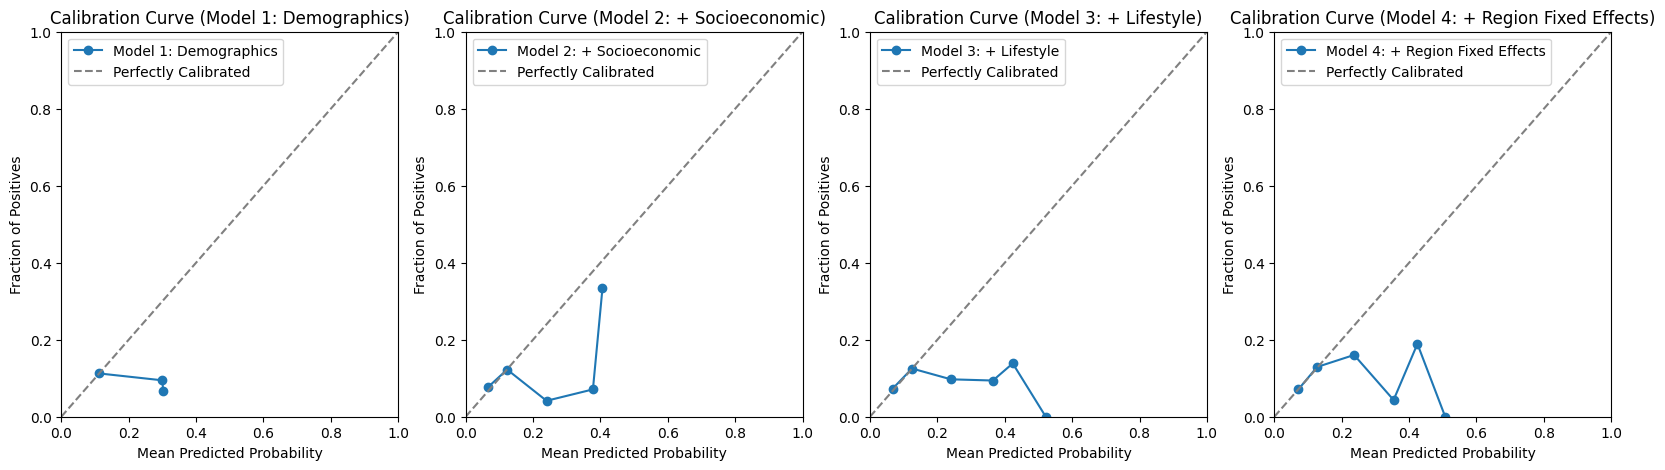

In [ ]:
# --- Results Storage ---
results = {}
roc_auc_scores = {}

# --- Diagnostics setup ---
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
axes = axes.flatten()

# --- Model fitting loop ---
for i, (model_name, predictors) in enumerate(models.items()):
    print(f"\n--- Fitting {model_name} ---")

    # --- Model Formula ---
    formula = f"CVD ~ {' + '.join(predictors)}"

    # --- Fit Logistic Regression ---
    if 'C(region)' in formula:  # Model 4
        try:
            model = sm.formula.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            continue
    else:  # Models 1-3
        try:
            model = sm.formula.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            continue

    # --- Store Results ---
    results[model_name] = {}
    results[model_name]['sample_size'] = len(df)

    # --- Calculate ORs and CIs ---
    results_df = calculate_odds_ratio_and_ci(model)
    results[model_name]['coefficients'] = results_df

    # --- Discrimination (AUC) ---
    y_prob = model.predict(df)
    auc = roc_auc_score(df['CVD'], y_prob)
    results[model_name]['auc'] = auc
    roc_auc_scores[model_name] = auc
    print(f"{model_name} AUC: {auc:.3f}")

    # --- Calibration ---
    brier_score = brier_score_loss(df['CVD'], y_prob)
    results[model_name]['brier_score'] = brier_score
    print(f"{model_name} Brier Score: {brier_score:.3f}")

    # --- Calibration Plot ---
    plot_calibration_curve(df['CVD'], y_prob, axes[i], model_name)


In [ ]:
import pandas as pd

# Load the results from the CSV file
results_df = pd.read_csv('tables/regression_models.csv')

# Print the report header
print("--- Regression Model Results Report ---")

# Loop through each model
for model_name in results_df['Model'].unique():
    print(f"\n--- {model_name} ---")

    # Filter the results for the current model
    model_df = results_df[results_df['Model'] == model_name]

    # Get the sample size
    sample_size = model_df['SampleSize'].iloc[0]
    print(f"Sample Size: {sample_size}")

    # Print the coefficients table
    print("\nCoefficients:")
    for index, row in model_df.iterrows():
        predictor = row['Predictor']
        OR = row['OR']
        SE = row['SE']
        lower_90CI = row['Lower90CI']
        upper_90CI = row['Upper90CI']
        lower_95CI = row['Lower95CI']
        upper_95CI = row['Upper95CI']
        p_value = row['PValue']
        #Note: SD is not available by default from statsmodels logistic regression
        #to get it we need to write more code
        print(f"  {predictor}:")
        print(f"    OR: {OR:.3f}")
        print(f"    SE: {SE:.3f}")
        print(f"    90% CI: ({lower_90CI:.3f}, {upper_90CI:.3f})")
        print(f"    95% CI: ({lower_95CI:.3f}, {upper_95CI:.3f})")
        print(f"    p-value: {p_value:.3f}")

    # Print AUC and Brier Score
    auc = model_df['AUC'].iloc[0]
    brier_score = model_df['BrierScore'].iloc[0]

    print(f"\nAUC: {auc:.3f}")
    print(f"Brier Score: {brier_score:.3f}")

--- Regression Model Results Report ---

--- Model 1: Demographics ---
Sample Size: 46162

Coefficients:
  Intercept:
    OR: 0.114
    SE: 0.048
    90% CI: (0.105, 0.123)
    95% CI: (0.104, 0.125)
    p-value: 0.000
  agea:
    OR: 1.001
    SE: 0.000
    90% CI: (1.001, 1.002)
    95% CI: (1.001, 1.002)
    p-value: 0.000
  gndr:
    OR: 1.015
    SE: 0.030
    90% CI: (0.966, 1.065)
    95% CI: (0.957, 1.075)
    p-value: 0.626

AUC: 0.745
Brier Score: 0.100

--- Model 2: + Socioeconomic ---
Sample Size: 46162

Coefficients:
  Intercept:
    OR: 0.153
    SE: 0.054
    90% CI: (0.140, 0.167)
    95% CI: (0.137, 0.170)
    p-value: 0.000
  agea:
    OR: 1.002
    SE: 0.000
    90% CI: (1.001, 1.002)
    95% CI: (1.001, 1.002)
    p-value: 0.000
  gndr:
    OR: 1.019
    SE: 0.030
    90% CI: (0.970, 1.070)
    95% CI: (0.961, 1.080)
    p-value: 0.535
  edulvlb:
    OR: 1.000
    SE: 0.000
    90% CI: (1.000, 1.000)
    95% CI: (1.000, 1.000)
    p-value: 0.000
  hinctnta:
    OR: 

**General Concepts**

- **Odds Ratio (OR)**: The odds ratio tells you how much more likely (or unlikely)  someone is to have CVD (the outcome) given a one-unit change in the predictor variable. An OR of 1 means there's no effect. OR > 1 means increased likelihood; OR < 1 means decreased likelihood.
- **Standard Error (SE)**: The standard error estimates the variability of the estimated odds ratio. Smaller SEs mean more precise estimates.
- **Confidence Intervals (CIs)**: Confidence intervals provide a range of plausible values for the true odds ratio. A 95% CI means that if you repeated the study many times, 95% of the calculated CIs would contain the true OR. The 90% CI is a narrower range, providing a more precise, but less certain, estimate.
- **P-value**: The p-value is the probability of observing the results (or more extreme results) if there is truly no association between the predictor and the outcome. A small p-value (typically p < 0.05) suggests that the association is statistically significant.
- **AUC(Area Under the ROC Curve)**: The AUC measures the model's ability to discriminate between people with and without CVD. An AUC of 0.5 indicates no discrimination (the model is no better than chance), while an AUC of 1 indicates perfect discrimination.
- **Brier Score**: The Brier score measures the accuracy of the predicted probabilities. A lower Brier score indicates better calibration (i.e., the predicted probabilities are closer to the actual outcomes).



**Model 1: Demographics**
- **Sample Size**: 46,162 people were included in this model.
- **Intercept**: The intercept (OR = 0.114) represents the baseline odds of CVD when all other predictors are zero. It's a reference point and not always directly interpretable. It has a very small p-value (p < 0.001), meaning it is statistically significant.
- **Age (agea)**: For every one-year increase in age, the odds of CVD increase slightly (OR = 1.001). This is statistically significant (p < 0.001).
- **Gender (gndr)**: Gender is not a significant predictor of CVD in this model (OR = 1.015, p = 0.626). The confidence intervals (90% and 95%) both cross 1, indicating that the true OR could be 1 (no effect).
- **AUC**: 0.745, indicating moderately good discrimination. The model does a reasonably good job of distinguishing between people with and without CVD based on age and gender alone.
- **Brier Score**: 0.100, indicating relatively good calibration.

**Model 2: + Socioeconomic**
- **Sample Size**: 46,162
- **Age (agea)**: Similar to Model 1, age is a statistically significant predictor (OR = 1.002, p < 0.001).
- **Gender (gndr)**: Not a significant predictor (OR = 1.019, p = 0.535).
- **Education (edulvlb)**: Education level has an odds ratio of 1.000, p < 0.001, implying that an increased level of education increases the odds of CVD with p < 0.001
- **Income (hinctnta)**: Higher income is associated with slightly lower odds of CVD (OR = 0.991), which is statistically significant (p < 0.001).
- **AUC**: 0.656, which is lower than Model 1. This suggests that adding socioeconomic factors actually decreased the model's ability to discriminate.
- **Brier Score**: 0.099, slightly better than Model 1, suggesting improved calibration.

**Model 3: + Lifestyle**
- **Sample Size**: 46,162
- **Age (agea)**: Significant predictor (OR = 1.002, p < 0.001).
- **Gender (gndr)**: Not a significant predictor (OR = 0.987, p = 0.670).
- **Education (edulvlb)**: Education level has an odds ratio of 1.000, p < 0.001, implying that an increased level of education increases the odds of CVD with p < 0.001
- **Income (hinctnta)**: Significant, negative association (OR = 0.991, p < 0.001).
-** Smoking (cgtsmok)**: Smoking is associated with increased odds of CVD (OR = 1.031, p < 0.001).
- **BMI**: BMI is significantly associated with CVD (OR = 1.001, p = 0.006)
- **Alcohol Frequency (alcfreq)**: OR = 1.004, p = 0.061 This predictor does not meet a typical p-value cut off of 0.05 for significance.
- **Fruit Consumption (etfruit)**: Not a significant predictor (OR = 0.998, p = 0.532).
- **Vegetable Consumption (eatveg)**: Eating vegetables increases odds of CVD. (OR = 1.008, p = 0.015).
- **Physical Activity (dosprt)**: More physical activity is associated with lower odds of CVD (OR = 0.973, p < 0.001).
- **AUC**: 0.645, slightly lower than Model 2.
- **Brier Score**: 0.098, slightly better than Model 2.

**Model 4: + Region Fixed Effects**
- **Sample Size**: 46,162
- **Region**: This model examines the impact of geographic region. The ORs are relative to the reference category (likely "East" since it's not explicitly listed). For example:
People in the "South" region have lower odds of CVD compared to those in "East" (OR = 0.829, p = 0.003).
People in the "Unknown" region have higher odds of CVD compared to those in "East" (OR = 1.160, p = 0.004).
"North" and "West" are not significantly different from East.

- **Other Predictors**: The effects of age, gender, education, income, smoking, BMI, diet, and physical activity are similar to Model 3, with slight adjustments due to the inclusion of region.
- **AUC**: 0.636, the lowest of all the models.
- **Brier Score**: 0.098.

The report provides both 90% and 95% confidence intervals for all the coefficients in each model.
